In [4]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW

Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=c38abb25-746e-4c03-96b0-36f72e3fc951
To: /content/train_data.csv
100% 635M/635M [00:11<00:00, 56.4MB/s]


In [5]:
!pip install datasets evaluate

In [6]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from datasets import Features, Value
from transformers import BitsAndBytesConfig
import gc
import torch
from torch.utils.data import DataLoader

In [8]:
features = Features({
    'reviewText': Value('string'),
    'overall': Value('int64')
})

# Load the dataset
dataset = load_dataset('csv', data_files='./train_data.csv', split='train', features=features)

# Convert the dataset to a pandas DataFrame for undersampling
df = dataset.to_pandas()

# Perform undersampling on the raw data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.drop(columns=['overall']), df['overall'])
balanced_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['overall'])], axis=1)

# Convert the balanced DataFrame back to a Hugging Face Dataset
balanced_dataset = Dataset.from_pandas(balanced_df)

# Filter out long reviews after undersampling
def filter_long_reviews(example):
    return len(example['reviewText']) <= 1000

filtered_dataset = balanced_dataset.filter(filter_long_reviews)

# Split the filtered dataset into train and validation sets
train_test_split = filtered_dataset.train_test_split(test_size=0.1, seed=42)
dt = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

# Load the tokenizer
model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples['reviewText'], truncation=True, padding=True, max_length=512)

encoded_dataset = dt.map(preprocess_function, batched=True)

# Map labels to start from 0
encoded_dataset = encoded_dataset.map(lambda x: {'labels': x['overall'] - 1})

# Set the format for PyTorch
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Final dataset dictionary with undersampled and preprocessed data
sampled_dataset = DatasetDict({
    'train': encoded_dataset['train'],
    'validation': encoded_dataset['validation']
})


Filter:   0%|          | 0/283780 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/217316 [00:00<?, ? examples/s]

Map:   0%|          | 0/24147 [00:00<?, ? examples/s]

Map:   0%|          | 0/217316 [00:00<?, ? examples/s]

Map:   0%|          | 0/24147 [00:00<?, ? examples/s]

In [9]:
del dataset, df, X_resampled, y_resampled, balanced_df, balanced_dataset, filtered_dataset, train_test_split, dt, encoded_dataset
gc.collect()
torch.cuda.empty_cache()

In [11]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=5,
    ignore_mismatched_sizes=True,
)

# model = prepare_model_for_kbit_training(model)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    report_to="tensorboard",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    label_names=["labels"],
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    macro_f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        "accuracy": accuracy["accuracy"],
        "macro_f1": macro_f1["f1"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sampled_dataset['train'],
    eval_dataset=sampled_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

model = model.merge_and_unload()
merged_model_path = "./fine_tuned_model"
model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

trainable params: 889,349 || all params: 125,538,826 || trainable%: 0.7084


<ipython-input-11-d664d4aa41e1>:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Macro F1
1000,0.970900,0.942350,0.585828,0.579875
2000,0.937500,0.933975,0.592703,0.576646
3000,0.931200,0.922692,0.599578,0.594235
4000,0.914400,0.892187,0.612291,0.606989
5000,0.912300,0.887470,0.610925,0.601078
6000,0.892800,0.873817,0.614859,0.613019
7000,0.889500,0.867266,0.616805,0.610815
8000,0.868700,0.855355,0.627614,0.624811
9000,0.863000,0.850871,0.628028,0.623620
10000,0.863900,0.850602,0.629146,0.622933


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

Evaluation results: {'eval_loss': 0.8396855592727661, 'eval_accuracy': 0.637636145276846, 'eval_macro_f1': 0.6378732522459417, 'eval_runtime': 95.8756, 'eval_samples_per_second': 251.858, 'eval_steps_per_second': 7.875, 'epoch': 3.0}


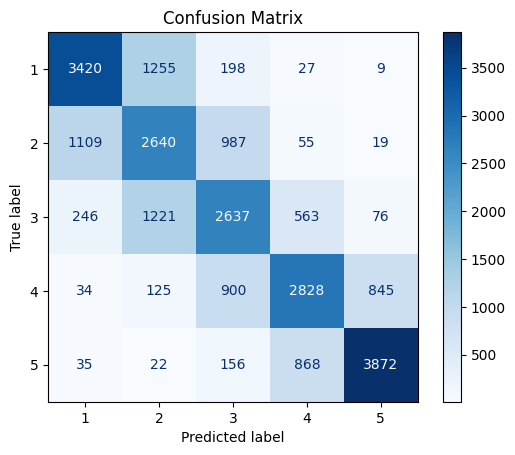

In [12]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

predictions = trainer.predict(sampled_dataset['validation'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

| Class | Precision | Recall | F1-Score | Support |
| :-- | :-- | :-- | :-- | :-- |
| 1 | 0.71 | 0.70 | 0.70 | 4909 |
| 2 | 0.50 | 0.55 | 0.52 | 4810 |
| 3 | 0.54 | 0.56 | 0.55 | 4743 |
| 4 | 0.65 | 0.60 | 0.62 | 4732 |
| 5 | 0.80 | 0.78 | 0.79 | 4953 |
|  |  |  |  |  |
| Accuracy |  |  | 0.64 | 24147 |
| Macro avg | 0.64 | 0.64 | 0.64 | 24147 |
| Weighted avg | 0.64 | 0.64 | 0.64 | 24147 |